# Intoduzione
Questo notebook continene un esperimento diviso in due step:
- 1 Determinazione del modello di regressione ottimale per il dataset in analisi
- 2 Calcolo della decomposizione della misura di GOF tra le variabili attraverso il calcolo degli Shapley values 

## Step 1: Determinazione del modello di regressione
Per prima cosa importiamo il dataset selezionato tramite il dataloader corrispondente

In [1]:
import  src.shapley.dataloaders.DataLoaders as dl


CHOSEN_DATASET = "CREDIT" #change me to change dataset

load_dataset = {
    "IRIS_REGRESSION": dl.load_iris_regression_dataset,
    "CREDIT": dl.load_Credit_dataset, #time consuming(12 predictors), unfeasible with not optimized calculation
    "INCOME": dl.load_Income2_dataset,
    "WOMAN_WAGE": dl.load_WomanWage
}


loaded_data = load_dataset[CHOSEN_DATASET]()

Il compito del dataloader è di restituire il dataset diviso in predittori e variabile di target, rimuovere eventuali colonne non informative, e fornire informazioni sulla presenza ed il nome delle variabili cateogoriche

In [2]:
X, y = loaded_data['data']
categorical_variables = loaded_data['categorical_variables']

Controlliamo la presenza di variabili categoriche

In [3]:
are_there_any_categorical_variables = bool(categorical_variables)
print(f"Are there any categorical variables? {are_there_any_categorical_variables}\n")
if(are_there_any_categorical_variables):
    categorical_variables_string = "".join([cat_var+" " for cat_var in categorical_variables])
    print(f"Categorical variables: {categorical_variables_string}")

Are there any categorical variables? True

Categorical variables: Gender Student Married Ethnicity 


### Data preprocessing
Procediamo al preprocessing del dataset: standardizziamo le variabili numeriche e codifichiamo le categoriche tramite One Hot Encoding

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np

if are_there_any_categorical_variables:
    std_scaler = StandardScaler()
    oh_encoder = OneHotEncoder(drop='first')
    non_categorical_variables = list(filter(lambda var: var not in categorical_variables, X.columns))
    X_non_cat = X[non_categorical_variables]
    X_cat = X[categorical_variables]
    X_non_cat_std = std_scaler.fit_transform(X_non_cat)
    X_cat_enc = oh_encoder.fit_transform(X_cat).toarray()
    X_preprocessed = np.concatenate((X_non_cat_std, X_cat_enc), axis=1)
    
else:
    std_scaler = StandardScaler()
    X_preprocessed = std_scaler.fit_transform(X)

### Selezione del modello
Determiniamo il migliore regressore per il dataset. Assegniamo ad ogni regressore un punteggio cross-validato.

In [5]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LassoLars
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

linear = LinearRegression()
polinomial = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())])
type(polinomial).__name__="PolynomialRegression"
lasso = Lasso(alpha=0.0001)
ridge = Ridge(alpha=0.1)
svr = SVR(kernel="linear", gamma="scale", C=5, epsilon=0.2)
rf_regressor = RandomForestRegressor()
ab_regressor = AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=50, learning_rate=1)
lars = LassoLars(alpha=0.001)
kn_regressor = KNeighborsRegressor(n_neighbors=10, weights="distance")

is_score_error = False

r2_scorer = make_scorer(r2_score)
mse_scorer = make_scorer(mean_squared_error)

loo = LeaveOneOut()
kf = KFold(3, shuffle=True)

models = [linear, polinomial, lasso, ridge, svr, rf_regressor, ab_regressor, lars, kn_regressor]
scores = [np.mean(cross_val_score(model, X_preprocessed, y, cv=kf, scoring=r2_scorer)) for model in models]

print("{: >20}\t{: >20}".format("Model", "Score"))
[print("{: >20}\t{: >20}".format(type(model).__name__, score)) for model,score in zip(models,scores)]
print()

if(not is_score_error):
    best_score = np.max(scores)
    best_score_idx= np.argmax(scores)
    best_model = models[best_score_idx]
else:
    best_score = np.min(scores)
    best_score_idx= np.argmin(scores)
    best_model = models[best_score_idx]

print(f"Best model: {type(best_model).__name__} \t Score: {best_score}")

/home/ric/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1180568.3716338566, tolerance: 5449.911522180451
  model = cd_fast.enet_coordinate_descent(
/home/ric/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1238967.9776676553, tolerance: 5664.267016479401
  model = cd_fast.enet_coordinate_descent(
/home/ric/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1238647.096338998, tolerance: 5739.484701872659
  model = cd_fast.enet_coordinate_descent(


               Model	               Score
    LinearRegression	   10330.03594349721
PolynomialRegression	   5508.831523414406
               Lasso	   9965.182085099781
               Ridge	  10366.265387612215
                 SVR	  25903.227040107653
RandomForestRegressor	  12623.409052197656
   AdaBoostRegressor	  10612.474071439678
           LassoLars	  10097.567429145436
 KNeighborsRegressor	   50347.77015577146

Best model: PolynomialRegression 	 Score: 5508.831523414406


## Step 2: Calcolo degli Shapley values
Utilizzando la classe ShapleyCalulator in 'src/shapley/Shapley.py' ed i risultati dello step precedente calcoliamo gli shapley values per ogni predittore. 
La classe ShapleyCalculator necessita di:
- un modello di regressione che rispetti le interfacce dei modelli di sklearn 
- una qualsiasi pipeline di preprocessing che rispetti le interfacce di sklearn
- una metrica di valutazione passata come callable
- Nell'eventualità di variabili categoriche, i nomi di quest'ultime ed un encoder

In [9]:
from src.shapley.shapley import ShapleyCalculator
from src.shapley.preprocessing import Preprocessor
import time


model = best_model
preprocessing_pipeline = StandardScaler()
score_fn = r2_score
categorical_encoder = OneHotEncoder(drop='first') if are_there_any_categorical_variables else None

preprocessor = Preprocessor(preprocessing_pipeline, categorical_encoder=categorical_encoder, categorical_variables=categorical_variables)
shapley_calculator = ShapleyCalculator(X, y, preprocessor, model, score_fn, is_score_error)

start_time = time.time()
sh_values = shapley_calculator.get_shapley_values(optimized=True)
end_time = time.time()
print(f"Computational time: {end_time-start_time}s")

Computational time: 51.787609577178955s


Possiamo stampare un summary dei risultati tramite il metodo print_summary() della classe ShapleyCalculator

In [10]:
shapley_calculator.print_summary()

Shapley calculator summary:

Scoring function: <function mean_squared_error at 0x7f6e4f14a3a0>

Score of the complete model: 4744.721059257689

Sum of the decomposed scores: 4985.848894191386

Shapley values for variable  (Score decomposition):
Variable name	Shapley-value(score)

    Income	-16624.578904463575
     Limit	-58390.23344421309
    Rating	-56353.097221551856
     Cards	20745.00781023865
       Age	23168.714610757826
 Education	20972.08766925226
    Gender	20786.813883419538
   Student	565.4131103316249
   Married	23342.435608269072
 Ethnicity	26773.285772150946

p-values:
Variable name	p-value

    Income	3.0679382371928403e-81
     Limit	1.461435848285565e-79
    Rating	3.954803467724536e-15
     Cards	0.0001610166400760623
       Age	0.24338177904614225
 Education	0.24791501454683829
    Gender	0.27816029226754263
   Student	0.5439768045449764
   Married	0.7087669998013264
 Ethnicity	0.7309451619039982


Possiamo stampare una rappresentazione grafica degli shapley values tramite il metodo plot_shapley() della classe ShapleyCalculator

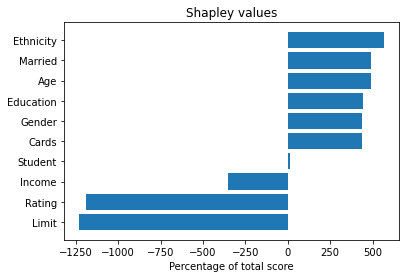

In [11]:
shapley_calculator.plot_shapley()